In [ ]:
import pickle 
import os
def load_pkl_files_to_dict(directory):
    mega_dict = {}

    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                if not isinstance(data, dict):
                    raise ValueError(f"File {filename} does not contain a dictionary.")
                mega_dict.update(data)

    return mega_dict

In [ ]:
#files in these functions are the creative captions generated at each distance
one_train = load_pkl_files_to_dict("./train/one/")
two_train = load_pkl_files_to_dict("./train/two/")
three_train = load_pkl_files_to_dict("./train/three/")
four_train = load_pkl_files_to_dict("./train/four/")
five_train = load_pkl_files_to_dict("./train/five/")


one_val = load_pkl_files_to_dict("./val/one/")
two_val = load_pkl_files_to_dict("./val/two/")
three_val = load_pkl_files_to_dict("./val/three/")
four_val = load_pkl_files_to_dict("./val/four/")
five_val = load_pkl_files_to_dict("./val/five/")
with open("./train_prompts.pkl", 'rb') as file:
    train = pickle.load(file)

with open("./val_prompts.pkl", 'rb') as file:
    val = pickle.load(file)
    

In [3]:
def get_image_path(subsets, og_set):
    subset_with_image = {}
    for subset in subsets:
        for k in subset:
            image_path = og_set[k][1]
            label = og_set[k][0]
            subset_with_image[k] = [subset[k],image_path,(label-1)] #value is a list with the caption, image path,task label
    return subset_with_image

In [4]:
train_all = get_image_path([one_train,two_train,three_train,four_train,five_train], train)
val_all = get_image_path([one_val,two_val,three_val,four_val,five_val], val)

In [5]:
def get_image_path_sub(split, dist):
    subset = {} #key is image path, and the val is the cap 
    for k in split:
        if split[k][2] == dist:
            subset[split[k][1]] = split[k][0]
    return subset

train_1 = get_image_path_sub(train_all, 0)
train_2 = get_image_path_sub(train_all, 1)
train_3 = get_image_path_sub(train_all, 2)
train_4 = get_image_path_sub(train_all, 3)
train_5 = get_image_path_sub(train_all, 4)

In [6]:
train_all_keys_present = set(train_1.keys()).intersection(set(train_2.keys()), set(train_3.keys()), set(train_4.keys()), set(train_5.keys()))

In [7]:
#do same for val:
def get_image_path_sub(split, dist):
    subset = {} #key is image path, and the val is the cap 
    for k in split:
        if split[k][2] == dist:
            subset[split[k][1]] = split[k][0]
    return subset

val_1 = get_image_path_sub(val_all, 0)
val_2 = get_image_path_sub(val_all, 1)
val_3 = get_image_path_sub(val_all, 2)
val_4 = get_image_path_sub(val_all, 3)
val_5 = get_image_path_sub(val_all, 4)

val_all_keys_present = set(val_1.keys()).intersection(set(val_2.keys()), set(val_3.keys()), set(val_4.keys()), set(val_5.keys()))


In [8]:
def get_img_id(path):
    filename = path.split("/")[-1]  # Get the filename
    number = int(filename.split(".")[0])  # Convert to int to remove leading zeros
    return number



In [ ]:
import json 

def load_coco_captions(file_path):
  """Loads COCO captions from a JSON file.

  Args:
    file_path: Path to the JSON file containing COCO captions.

  Returns:
    A dictionary where keys are image IDs and values are lists of captions.
  """
  with open(file_path, 'r') as f:
    data = json.load(f)
  return data
train_captions = load_coco_captions("./coco_ann2014/annotations/captions_train2014.json")
val_captions = load_coco_captions("./coco_ann2014/annotations/captions_val2014.json")

#download the foil dataset from https://foilunitn.github.io/
foil_train_captions = load_coco_captions("./foilv1.0_train_2017.json")
foil_val_captions = load_coco_captions("./foilv1.0_test_2017.json")


In [46]:
from collections import defaultdict
def get_captions_by_image_id(captions):
    all_caps = defaultdict(list)
    for cap in captions:
        all_caps[cap['image_id']].append(cap['caption'])
    
    return all_caps

def get_foil_by_image_id(captions):
    all_caps = defaultdict(list)
    for cap in captions:
        if cap['foil'] == True:
            all_caps[cap['image_id']].append(cap['caption'])
    return all_caps

train_caps_by_id = get_captions_by_image_id(train_captions['annotations'])
val_caps_by_id = get_captions_by_image_id(val_captions['annotations'])
foil_train_caps_by_id = get_foil_by_image_id(foil_train_captions['annotations'])
foil_val_caps_by_id = get_foil_by_image_id(foil_val_captions['annotations'])


In [47]:
#for each creative cap id, get one original cap and one foil cap in each of the set 
import random
def get_og_foil_caps(ids, original_caps, original_foil_caps):
    #key is image id, the val is one of the caps
    og_caps = defaultdict(str)
    foil_caps = defaultdict(str)
    for id in ids:
        image_id = get_img_id(id)
        if (image_id in original_caps) and (image_id in original_foil_caps):
            og_caps[id] = random.choice(original_caps[image_id])
            foil_caps[id] = random.choice(original_foil_caps[image_id])

    return og_caps, foil_caps

train_og, train_foil = get_og_foil_caps(list(train_all_keys_present), train_caps_by_id, foil_train_caps_by_id)
val_og, val_foil = get_og_foil_caps(list(val_all_keys_present), val_caps_by_id, foil_val_caps_by_id)


In [51]:
def get_all(original, foils, ones, twos, threes, fours, fives):
    images = []
    og = []
    foil = []
    one = []
    two = []
    three = []
    four = []
    five = []
    for key in original:
        images.append(key)
        og.append(original[key])
        foil.append(foils[key])
        one.append(ones[key])
        two.append(twos[key])
        three.append(threes[key])
        four.append(fours[key])
        five.append(fives[key])
    
    return images, og, foil, one, two, three, four, five
timages, tog, tfoil, tone, ttwo, tthree, tfour, tfive = get_all(train_og, train_foil,train_1, train_2, train_3, train_4, train_5)
vimages, vog, vfoil, vone, vtwo, vthree, vfour, vfive = get_all(val_og, val_foil,val_1, val_2, val_3, val_4, val_5)




In [52]:
all_images = timages + vimages
all_og = tog + vog
all_foil = tfoil + vfoil 
all_one = tone + vone
all_two = ttwo + vtwo
all_three = tthree + vthree
all_four = tfour + vfour 
all_five = tfive + vfive

In [ ]:
#get the clip scores of each of these 
from tqdm import tqdm 
import torch
from PIL import Image
def get_text_features(texts,model, tokenizer, device, batch_size=512):
    # Iterate over batches
    all_text_features = []
    for batch_start in tqdm(range(0, len(texts), batch_size), desc="Processing Batches"):
        batch_end = min(batch_start + batch_size, len(texts))
        text_batch = texts[batch_start:batch_end]
        # Encode text and images
        with torch.no_grad():  # Prevent gradient computation to save memory
            text_tokens = tokenizer(text_batch).to(device)
            text_features = model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize
            all_text_features.append(text_features)
    
    text_features = torch.cat(all_text_features, dim=0)
    return text_features

def get_image_features(images,model, preprocess, device, batch_size=512):
    # Iterate over batches
    all_image_features = []
    for batch_start in tqdm(range(0, len(images), batch_size), desc="Processing Batches"):
        batch_end = min(batch_start + batch_size, len(images))
        images_batch = images[batch_start:batch_end]
        # Encode text and images
        with torch.no_grad():  # Prevent gradient computation to save memory
            images_batch = [preprocess(Image.open(file_path).convert("RGB")) for file_path in images_batch]
            image_batch = torch.stack(images_batch).to(device)  # Ensure tensor
            image_features = model.encode_image(image_batch)  # Encode images
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize
            
            all_image_features.append(image_features)
    
    img_features = torch.cat( all_image_features, dim=0)
    return img_features


In [55]:
import open_clip
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
clip_model.to(device)

og_text = get_text_features(all_og,clip_model, tokenizer, device, batch_size=1024)
foil_text = get_text_features(all_foil,clip_model, tokenizer, device, batch_size=1024)
one_text = get_text_features(all_one,clip_model, tokenizer, device, batch_size=1024)
two_text = get_text_features(all_two,clip_model, tokenizer, device, batch_size=1024)
three_text = get_text_features(all_three,clip_model, tokenizer, device, batch_size=1024)
four_text = get_text_features(all_four,clip_model, tokenizer, device, batch_size=1024)
five_text = get_text_features(all_five,clip_model, tokenizer, device, batch_size=1024)
all_images = get_image_features(all_images,clip_model,preprocess, device, batch_size=1024)

Processing Batches: 100%|██████████| 62/62 [12:44<00:00, 12.32s/it]


In [56]:
import torch.nn.functional as F
def get_scores(img_features, text_features):
    similarity_scores = F.cosine_similarity(img_features, text_features, dim=1)
    return similarity_scores

og_scores = get_scores(all_images, og_text)
foil_scores = get_scores(all_images, foil_text)
one_scores = get_scores(all_images, one_text)
two_scores = get_scores(all_images, two_text)
three_scores = get_scores(all_images, three_text)
four_scores = get_scores(all_images, four_text)
five_scores = get_scores(all_images, five_text)

In [57]:
print(f"avg og {og_scores.mean()}")
print(f"avg foil {foil_scores.mean()}")
print(f"avg one {one_scores.mean()}")
print(f"avg two {two_scores.mean()}")
print(f"avg three {three_scores.mean()}")
print(f"avg four {four_scores.mean()}")
print(f"avg five {five_scores.mean()}")

avg og 0.3086344003677368
avg foil 0.2645479440689087
avg one 0.29562345147132874
avg two 0.2917453646659851
avg three 0.2826076149940491
avg four 0.27292969822883606
avg five 0.26016101241111755


In [75]:
def get_percentage_times(cap_1, cap_2):
    #returns percentage of time cap 1  > cap 2 in scores
    times = 0
    for i in range(0,len(cap_1)):
        if cap_1[i] > cap_2[i]:
            times += 1
    return times/len(cap_1)

og_vs_one = get_percentage_times(og_scores,one_scores)
og_vs_two = get_percentage_times(og_scores,two_scores)
og_vs_three = get_percentage_times(og_scores,three_scores)
og_vs_four = get_percentage_times(og_scores,four_scores)
og_vs_five = get_percentage_times(og_scores,five_scores)

In [76]:
foil_vs_one = get_percentage_times(foil_scores,one_scores)
foil_vs_two = get_percentage_times(foil_scores,two_scores)
foil_vs_three = get_percentage_times(foil_scores,three_scores)
foil_vs_four = get_percentage_times(foil_scores,four_scores)
foil_vs_five = get_percentage_times(foil_scores,five_scores)

In [77]:
og_vs_foil = get_percentage_times(og_scores,foil_scores)

In [93]:
foil_vs_og = get_percentage_times(foil_scores,og_scores)

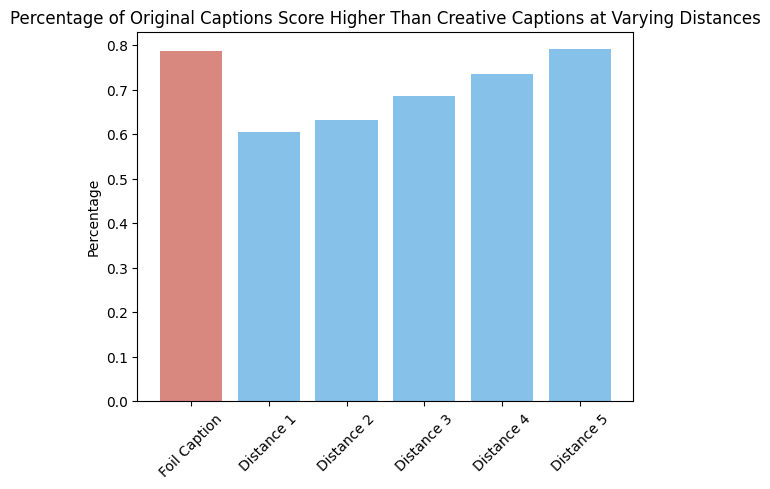

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
og_plots= [og_vs_foil,og_vs_one, og_vs_two, og_vs_three, og_vs_four, og_vs_five]
foil_plots = [foil_vs_og,foil_vs_one, foil_vs_two, foil_vs_three, foil_vs_four, foil_vs_five]
colors = ['#D98880', '#85C1E9', '#85C1E9', '#85C1E9', '#85C1E9','#85C1E9'] 
labels = ["Foil Caption", "Distance 1", "Distance 2", 
          "Distance 3", "Distance 4","Distance 5"]


# Create the bar graph
plt.bar(labels, og_plots, color=colors)

# Add labels and title
plt.ylabel("Percentage")
plt.title("Percentage of Original Captions Score Higher Than Creative Captions at Varying Distances")
plt.xticks(rotation=45) 
# Show the plot
plt.show()


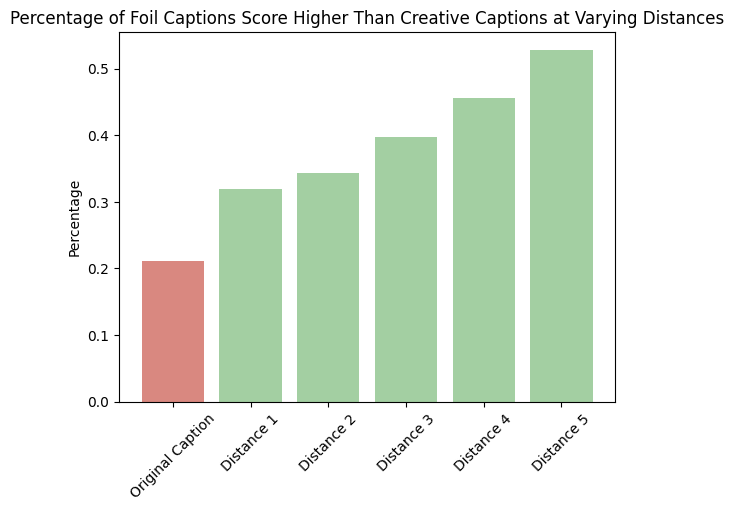

In [96]:
# Sample data
colors = ['#D98880','#A3CFA2', '#A3CFA2', '#A3CFA2', '#A3CFA2', '#A3CFA2','#A3CFA2'] 
labels = ["Original Caption","Distance 1", "Distance 2", 
          "Distance 3", "Distance 4","Distance 5"]


# Create the bar graph
plt.bar(labels, foil_plots, color=colors)

# Add labels and title
plt.ylabel("Percentage")
plt.title("Percentage of Foil Captions Score Higher Than Creative Captions at Varying Distances")
plt.xticks(rotation=45) 
# Show the plot
plt.show()